## Importação da bibliotecas

In [1]:
%matplotlib inline
import numpy as np
import os
import pandas as pd

import keras
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers import Input, Embedding
from keras.models import Model
from keras.regularizers import l2
from keras.layers.core import Flatten, Dense, Dropout
from keras.optimizers import SGD, RMSprop, Adam

np.set_printoptions(precision=3)


Using TensorFlow backend.


In [2]:
batch_size=64

## Leitura dos Dados - Movielens dataset

- [Movielens - Readme](http://files.grouplens.org/datasets/movielens/ml-latest-small-README.html)
- Movielens - Small data set - 100.000 avaliações:[ml-latest-small.zip](http://files.grouplens.org/datasets/movielens/ml-latest-small.zip)

F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4, Article 19 (December 2015).


In [3]:
dirname = 'mlens-latest-small'
origin = 'http://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
fpath = get_file(dirname,origin=origin,extract=True)

In [4]:
print(os.path.dirname(fpath))
#/Users/robertoalotufo/.keras/datasets/ml

/Users/robertoalotufo/.keras/datasets


In [5]:
ratings = pd.read_csv(os.path.dirname(fpath) + '/ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


## Leitura dos títulos dos filmes

Just for display purposes, let's read in the movie names too.

In [6]:
#movie_names = pd.read_csv(os.path.dirname(fpath) + '/ml-latest-small/movies.csv')
movie_names = pd.read_csv(os.path.dirname(fpath) + '/ml-latest-small/movies.csv').set_index('movieId')['title'].to_dict()
print('movieId=31:',movie_names[31])
print('movieId=1029:',movie_names[1029])

movieId=31: Dangerous Minds (1995)
movieId=1029: Dumbo (1941)


## Tratamento dos índices de usuários e filmes para ficarem sequenciais

In [7]:
# Exercício para entender o funcionamento do np.unique
a = np.array([205, 205, 300, 205, 205, 300, 4])
index_inverse, ord_a = np.unique(a,return_inverse=True)
print('a:',a)
print('index_inverse:',index_inverse)
print('ord_a:',ord_a)
print(index_inverse[ord_a])

a: [205 205 300 205 205 300   4]
index_inverse: [  4 205 300]
ord_a: [1 1 2 1 1 2 0]
[205 205 300 205 205 300   4]


In [8]:
ratings = np.array(ratings)
n_samples = ratings.shape[0]
print(ratings.dtype,ratings.shape)
print('n_samples:',n_samples)

float64 (100004, 4)
n_samples: 100004


In [9]:
movieId = ratings[:,1].astype(np.int) # movieId em ordem qualquer com múltipla ocorrência
movieId_index_inverse,movieId_ord = np.unique(movieId,return_inverse=True)
n_movies = movieId_ord.max()+1
print('movieId (original):',movieId[:15])
print('movieId_ord (contínuo):',movieId_ord[:15])
print('n. de filmes:',n_movies)

movieId (original): [  31 1029 1061 1129 1172 1263 1287 1293 1339 1343 1371 1405 1953 2105 2150]
movieId_ord (contínuo): [  30  833  859  906  931 1017 1041 1047 1083 1087 1111 1140 1515 1665 1708]
n. de filmes: 9066


In [10]:
ratings_ordered = ratings[:,:3].copy()
ratings_ordered[:,1]=movieId_ord
np.set_printoptions(formatter={'float': '{: 0.1f}'.format})
print(ratings_ordered[:5])

[[ 1.0  30.0  2.5]
 [ 1.0  833.0  3.0]
 [ 1.0  859.0  3.0]
 [ 1.0  906.0  2.0]
 [ 1.0  931.0  4.0]]


In [11]:
# verificando se os userIds estão ordenados
userId = ratings_ordered[:,0].astype(np.int)
userId_index_inverse, userId_ord = np.unique(userId,return_inverse=True)
n_users = userId_ord.max()+1
print('userId (original):',userId[:15])
print('userId_ord (contínuo):',userId_ord[:15])
print('n. de usuários:', n_users)

userId (original): [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
userId_ord (contínuo): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
n. de usuários: 671


In [12]:
ratings_ordered[:,0]=userId_ord
print(ratings_ordered[:5])

[[ 0.0  30.0  2.5]
 [ 0.0  833.0  3.0]
 [ 0.0  859.0  3.0]
 [ 0.0  906.0  2.0]
 [ 0.0  931.0  4.0]]


## Visualização da matriz de ratings

(671, 9066)


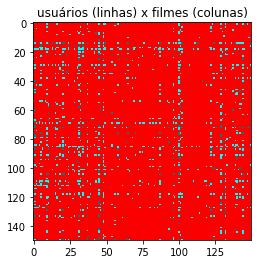

In [88]:
grid_ratings_ordered = -1. * np.ones((n_users,n_movies))
uId = (ratings_ordered[:,0]).astype(np.int)
mId = (ratings_ordered[:,1]).astype(np.int)
grid_ratings_ordered[uId,mId] = ratings_ordered[:,2] # Criação da matriz
print(grid_ratings_ordered.shape)

show_ratings = np.zeros((n_users,n_movies,3))
show_ratings[:,:,0] = np.where(grid_ratings_ordered == -1., 5., 0.  )
show_ratings[:,:,1] = np.where(grid_ratings_ordered == -1., 0., grid_ratings_ordered)
show_ratings[:,:,2] = np.where(grid_ratings_ordered == -1., 0., grid_ratings_ordered)


import matplotlib.pyplot as plt
plt.title('usuários (linhas) x filmes (colunas)')
#plt.xlabel('usuarios')
#plt.ylabel('filmes')
plt.imshow(show_ratings[:150,:150,:])
plt.show()

(array([ 1101.0,  3326.0,  1687.0,  7271.0,  4449.0,  20064.0,  10538.0,
         28750.0,  7723.0,  15095.0]),
 array([ 0.5,  0.9,  1.4,  1.9,  2.3,  2.8,  3.2,  3.6,  4.1,  4.5,  5.0]),
 <a list of 10 Patch objects>)

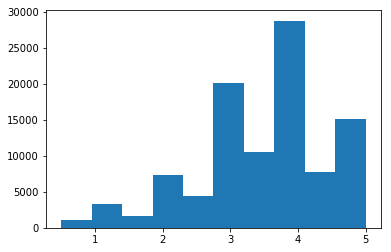

In [16]:
gt = grid_ratings_ordered.copy().reshape(-1)

plt.hist(gt[gt>=0])

## Create subset for Excel - Melhores filmes e usuários mais ativos

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [17]:
# filmes melhores recomendados, maior soma dos ratings
gt_top = gt.copy()
gt_top[gt<0]=np.NaN
gt_2d = gt_top.reshape((n_users,n_movies))
best_movies = np.nansum(gt_2d,axis=0)
i_best_movies = np.argsort(best_movies)[::-1]
print(i_best_movies[:10])
print(best_movies[i_best_movies[:10]])
for i in i_best_movies[:5]:
    print(movie_names[movieId_index_inverse[i]])

[ 284  321  266  525  232 2062  472  427  953    0]
[ 1395.5  1382.5  1379.0  1258.0  1228.5  1083.5  1050.0  1015.5  990.5
  956.5]
Shawshank Redemption, The (1994)
Forrest Gump (1994)
Pulp Fiction (1994)
Silence of the Lambs, The (1991)
Star Wars: Episode IV - A New Hope (1977)


In [18]:
# filmes mais populares, maior número dos ratings
gt_pop = gt.copy()
gt_pop[gt>=-3]=1
gt_pop[gt<0] =0
gt_pop_2d = gt_pop.reshape((n_users,n_movies))
popular_movies = gt_pop_2d.sum(axis=0)
i_popular_movies = np.argsort(popular_movies)[::-1]
print('indices filmes  :',movieId_index_inverse[i_popular_movies[:10]])
print('soma dos ratings:',popular_movies[i_popular_movies[:10]])
for i in i_popular_movies[:10]:
    print('indice_original:',movieId_index_inverse[i],'títulos:',
          movie_names[movieId_index_inverse[i]])
movieId_index_inverse[i_popular_movies[:10]]

indices filmes  : [ 356  296  318  593  260  480 2571    1  527  589]
soma dos ratings: [ 341.0  324.0  311.0  304.0  291.0  274.0  259.0  247.0  244.0  237.0]
indice_original: 356 títulos: Forrest Gump (1994)
indice_original: 296 títulos: Pulp Fiction (1994)
indice_original: 318 títulos: Shawshank Redemption, The (1994)
indice_original: 593 títulos: Silence of the Lambs, The (1991)
indice_original: 260 títulos: Star Wars: Episode IV - A New Hope (1977)
indice_original: 480 títulos: Jurassic Park (1993)
indice_original: 2571 títulos: Matrix, The (1999)
indice_original: 1 títulos: Toy Story (1995)
indice_original: 527 títulos: Schindler's List (1993)
indice_original: 589 títulos: Terminator 2: Judgment Day (1991)


array([ 356,  296,  318,  593,  260,  480, 2571,    1,  527,  589])

In [19]:
# usuários mais ativos, maior soma de ratings dados
top_users = np.nansum(gt_2d,axis=1)
i_top_users = np.argsort(top_users)[::-1]
print(i_top_users[:10])
print(top_users[i_top_users[:10]])
i_top_users[:10]

[546 563  72 623  14 451 467  29 379 293]
[ 8050.0  6636.0  5432.5  5021.5  4457.0  4273.5  3829.0  3806.5  3578.5
  3394.5]


array([546, 563,  72, 623,  14, 451, 467,  29, 379, 293])

In [20]:
ii_top_users = i_top_users[:10].astype(np.int)
ii_top_users

array([546, 563,  72, 623,  14, 451, 467,  29, 379, 293])

In [21]:
ii_popular_movies = i_popular_movies[:10].astype(np.int)
ii_popular_movies

array([ 321,  266,  284,  525,  232,  427, 2062,    0,  472,  522])

In [22]:
gt_2d[np.ix_(ii_top_users,ii_popular_movies)]

array([[ 2.0,  5.0,  5.0,  5.0,  nan,  3.0,  3.5,  3.5,  5.0,  nan],
       [ 3.0,  5.0,  nan,  5.0,  2.0,  5.0,  3.0,  4.0,  4.0,  5.0],
       [ 5.0,  5.0,  5.0,  4.5,  4.5,  4.0,  4.5,  5.0,  5.0,  3.0],
       [ 3.0,  5.0,  nan,  5.0,  5.0,  3.0,  2.0,  5.0,  nan,  3.0],
       [ 1.0,  5.0,  2.0,  5.0,  5.0,  3.0,  5.0,  2.0,  4.0,  4.0],
       [ 4.0,  5.0,  5.0,  5.0,  4.0,  5.0,  2.0,  3.5,  4.0,  4.0],
       [ 3.0,  3.5,  3.5,  3.0,  3.5,  2.5,  3.0,  4.0,  nan,  nan],
       [ 5.0,  5.0,  5.0,  4.0,  4.0,  4.0,  3.0,  4.0,  5.0,  4.0],
       [ 5.0,  5.0,  4.0,  5.0,  4.0,  4.0,  5.0,  4.0,  nan,  4.0],
       [ 4.0,  nan,  3.0,  nan,  4.0,  4.0,  4.5,  4.0,  4.0,  3.0]])

In [23]:
#pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)


## Divisão dos dados em treinamento e validação

In [24]:
user_min, user_max, movie_min, movie_max = (ratings_ordered[:,0].min(), 
                                            ratings_ordered[:,0].max(), 
                                            ratings_ordered[:,1].min(), 
                                            ratings_ordered[:,1].max())
user_min, user_max, movie_min, movie_max

(0.0, 670.0, 0.0, 9065.0)

In [25]:
n_users, n_movies, n_samples

(671, 9066, 100004)

This is the number of latent factors in each embedding.

In [26]:
n_factors = 50

In [27]:
np.random.seed = 42

Randomly split into training and validation.

In [28]:
msk = np.random.rand(n_samples) < 0.8
train = ratings_ordered[msk]
valid = ratings_ordered[~msk]
print('train:',train.shape[0],' amostras:\n',train[:5])
print('valid:',valid.shape[0],' amostras:\n',valid[:5])

train: 80044  amostras:
 [[ 0.0  859.0  3.0]
 [ 0.0  906.0  2.0]
 [ 0.0  931.0  4.0]
 [ 0.0  1017.0  2.0]
 [ 0.0  1041.0  2.0]]
valid: 19960  amostras:
 [[ 0.0  30.0  2.5]
 [ 0.0  833.0  3.0]
 [ 0.0  1083.0  3.5]
 [ 0.0  1111.0  2.5]
 [ 1.0  48.0  4.0]]


## Dot product

The most basic model is a dot product of a movie embedding and a user embedding. Let's see how well that works:

In [29]:
user_in = Input(shape=(1,), dtype='int64', name='user_in')
u = Embedding(n_users, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(user_in)
movie_in = Input(shape=(1,), dtype='int64', name='movie_in')
m = Embedding(n_movies, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(movie_in)
x = keras.layers.dot([u, m],axes=-1)
x = Flatten()(x)
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_in (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
movie_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 1, 50)         33550                                        
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 1, 50)         453300                                       
___________________________________________________________________________________________

In [30]:
train_userId = train[:,0]
train_movieId = train[:,1]
train_rating = train[:,2]
print('train shapes:',train_userId.shape, train_movieId.shape, train_rating.shape)

valid_userId = valid[:,0]
valid_movieId = valid[:,1]
valid_rating = valid[:,2]
print('valid shapes:',valid_userId.shape, valid_movieId.shape, valid_rating.shape)

train shapes: (80044,) (80044,) (80044,)
valid shapes: (19960,) (19960,) (19960,)


In [31]:
model.fit([train_userId, train_movieId], train_rating, batch_size=64, epochs=1, 
          validation_data=([valid_userId, valid_movieId], valid_rating))

Train on 80044 samples, validate on 19960 samples
Epoch 1/1
80044/80044 [==============================] - 43s - loss: 10.0140 - val_loss: 4.3852

The [best benchmarks](http://www.librec.net/example.html) are a bit over 0.9, so this model doesn't seem to be working that well...

We can use the model to generate predictions by passing a pair of ints - a user id and a movie id. For instance, this predicts that user #3 would really enjoy movie #6.

In [32]:
model.predict([np.array([3]), np.array([6])])

array([[ 2.6]], dtype=float32)

##  Neural net

Rather than creating a special purpose architecture (like our dot-product with bias earlier), it's often both easier and more accurate to use a standard neural network. Let's try it! Here, we simply concatenate the user and movie embeddings into a single vector, which we feed into the neural net.

In [33]:
user_in = Input(shape=(1,),dtype='int64', name='user_in')
u = Embedding(n_users, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(user_in)

movie_in = Input(shape=(1,),dtype='int64', name='movie_in')
m = Embedding(n_movies, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(movie_in)

In [34]:
x = keras.layers.concatenate([u, m])
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
nn = Model([user_in, movie_in], x)
nn.compile(Adam(0.001), loss='mse')
print(nn.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_in (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
movie_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_3 (Embedding)          (None, 1, 50)         33550                                        
____________________________________________________________________________________________________
embedding_4 (Embedding)          (None, 1, 50)         453300                                       
___________________________________________________________________________________________

In [ ]:
nn.fit([train_userId, train_movieId], train_rating, batch_size=64, epochs=8, # was 8 
          validation_data=([valid_userId, valid_movieId], valid_rating))

Train on 80044 samples, validate on 19960 samples
Epoch 1/8
80044/80044 [==============================] - 37s - loss: 1.5238 - val_loss: 0.8910 - ETA: 33s - loss: 1.6424

This improves on our already impressive accuracy even further!

In [55]:
nn.predict([np.array([3]), np.array([6])])

array([[ 4.0]], dtype=float32)

## Calculando e visualizando as predições para todos os outros usuários/filmes

In [82]:
#grid_ratings_ordered[uId,mId] = ratings_ordered[:,2] # Criação da matriz
n_predict = 102400
n2p_user,n2p_movie = np.nonzero(grid_ratings_ordered==-1)
recommend = nn.predict([n2p_user, n2p_movie])

In [84]:
gg = grid_ratings_ordered.copy()
gg[n2p_user,n2p_movie] = recommend[:,0]



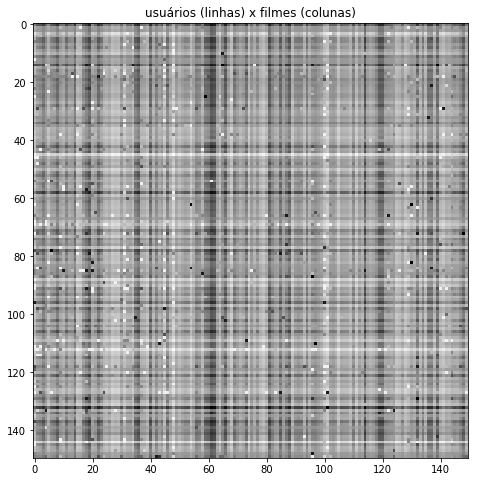

In [87]:
plt.figure(figsize=(8,8))
plt.title('usuários (linhas) x filmes (colunas)')
#plt.xlabel('usuarios')
#plt.ylabel('filmes')
plt.imshow(gg[:150,:150],cmap='gray')
plt.show()

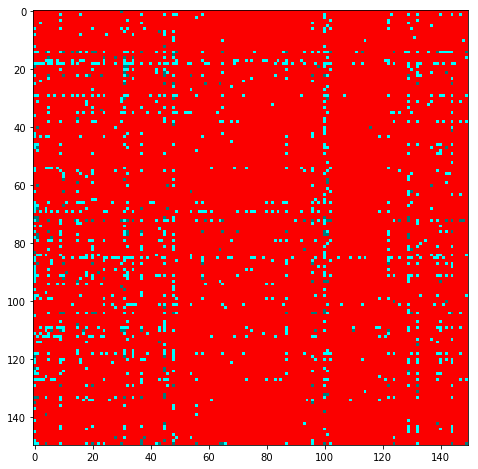

In [90]:
plt.figure(figsize=(8,8))
plt.imshow(show_ratings[:150,:150,:])

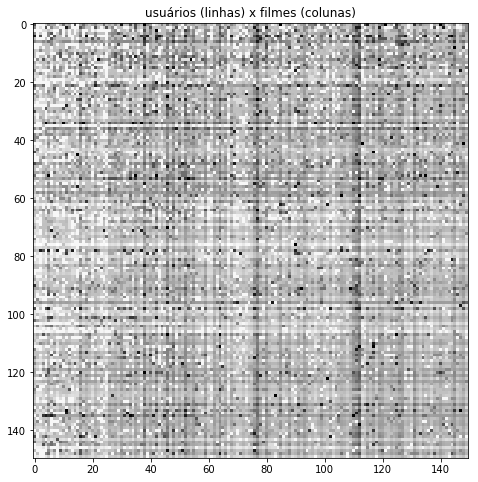

In [91]:
io_popular_movies = i_popular_movies.astype(np.int)
io_top_users = i_top_users.astype(np.int)
gg_ord = gg[np.ix_(io_top_users,io_popular_movies)]
plt.figure(figsize=(8,8))
plt.title('usuários (linhas) x filmes (colunas)')
plt.imshow(gg_ord[:150,:150],cmap='gray')
plt.show()

## Analyze results

To make the analysis of the factors more interesting, we'll restrict it to the top 2000 most popular movies.

In [56]:
topMovies = i_popular_movies[:2000]

First, we'll look at the movie bias term. We create a 'model' - which in keras is simply a way of associating one or more inputs with one more more outputs, using the functional API. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

We can now do the same thing for the embeddings.

In [57]:
get_movie_emb = Model(movie_in, m)
movie_emb = np.squeeze(get_movie_emb.predict([topMovies]))
movie_emb.shape

(2000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [58]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [59]:
fac0 = movie_pca[0]
isort = np.argsort(fac0)[::-1]

Here's the 1st component. It seems to be 'critically acclaimed' or 'classic'.

In [60]:
for ii in isort[:15]:
    print(fac0[ii],movie_names[movieId_index_inverse[ii]])

0.0525325593333 Godzilla (Gojira) (1954)
0.0519018675698 Chariots of Fire (1981)
0.0517701951155 Back to the Future Part II (1989)
0.0515441936524 Thirty-Two Short Films About Glenn Gould (1993)
0.0505975200807 Kiss Me, Guido (1997)
0.0504195658801 Elizabeth (1998)
0.0494838616543 Gold Diggers: The Secret of Bear Mountain (1995)
0.0476038732733 Game, The (1997)
0.0472558853031 Wide Awake (1998)
0.0472506829547 Patch Adams (1998)
0.0464246273519 Governess, The (1998)
0.0461645303238 Wings of the Dove, The (1997)
0.0456820941309 Bullets Over Broadway (1994)
0.0453302885811 Santa with Muscles (1996)
0.0448736745718 Winnie the Pooh and the Blustery Day (1968)


In [61]:
for ii in isort[-15:]:
    print(fac0[ii],movie_names[movieId_index_inverse[ii]])

-0.0513388099819 Nixon (1995)
-0.0517059987872 Beat the Devil (1953)
-0.0535865340154 Bio-Dome (1996)
-0.0539546655226 Wedding Gift, The (1994)
-0.0540847579588 Naked (1993)
-0.0543932883048 Jumanji (1995)
-0.0551031878023 Before the Rain (Pred dozhdot) (1994)
-0.0552973339775 Kicking and Screaming (1995)
-0.0555791659692 Madness of King George, The (1994)
-0.0561040621878 Othello (1995)
-0.0568409648616 Grumpier Old Men (1995)
-0.0570710992253 La Cérémonie (1995)
-0.0577706385098 Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)
-0.0586665916777 Sudden Death (1995)
-0.0601568109283 Coup de torchon (Clean Slate) (1981)


The 2nd is 'hollywood blockbuster'.

In [62]:
fac1 = movie_pca[1]
isort = np.argsort(fac1)[::-1]

In [63]:
for ii in isort[:15]:
    print(fac1[ii],movie_names[movieId_index_inverse[ii]])

0.0659998747648 Trainspotting (1996)
0.060891338135 Wings of the Dove, The (1997)
0.0564153496878 Island of Dr. Moreau, The (1996)
0.0555846703558 Inspector General, The (1949)
0.0500952589577 Waking Ned Devine (a.k.a. Waking Ned) (1998)
0.0497459109224 Saboteur (1942)
0.0491929061942 Birds, The (1963)
0.0489517482268 Gandhi (1982)
0.0488783866858 Patch Adams (1998)
0.0486984955711 Prefontaine (1997)
0.0486983392677 Damsel in Distress, A (1937)
0.0486178259323 Howling, The (1980)
0.048443432131 Celtic Pride (1996)
0.0475189950225 Blue in the Face (1995)
0.0475002305652 Man Who Knew Too Little, The (1997)


In [64]:
for ii in isort[-15:]:
    print(fac1[ii],movie_names[movieId_index_inverse[ii]])

-0.0631180526882 Barney's Great Adventure (1998)
-0.0632908428182 Poltergeist II: The Other Side (1986)
-0.0633886038922 Nightmare Before Christmas, The (1993)
-0.0635665819278 Flower of My Secret, The (La flor de mi secreto) (1995)
-0.0638187078506 Madame Butterfly (1995)
-0.0641108711273 Red Firecracker, Green Firecracker (Pao Da Shuang Deng) (1994)
-0.0645048445156 Private Benjamin (1980)
-0.0646341716364 Virtuosity (1995)
-0.0652933923732 Englishman Who Went Up a Hill But Came Down a Mountain, The (1995)
-0.0656326754017 Murder at 1600 (1997)
-0.0667433703805 Candyman: Farewell to the Flesh (1995)
-0.0668933000065 Star Trek VI: The Undiscovered Country (1991)
-0.0710544723463 My Fellow Americans (1996)
-0.0715295586629 Air Force One (1997)
-0.0772895792064 Superweib, Das (1996)


The 3rd is 'violent vs happy'.

In [65]:
fac2 = movie_pca[2]
isort = np.argsort(fac2)[::-1]

In [66]:
for ii in isort[:15]:
    print(fac2[ii],movie_names[movieId_index_inverse[ii]])

0.105910594066 Sense and Sensibility (1995)
0.0825147838532 Wonderful, Horrible Life of Leni Riefenstahl, The (Macht der Bilder: Leni Riefenstahl, Die) (1993)
0.075890002744 Blues Brothers 2000 (1998)
0.07324912614 Mrs. Doubtfire (1993)
0.0680018581165 Kim (1950)
0.066333815677 Jury Duty (1995)
0.0662124629365 Angela (1995)
0.0650463840267 Quick and the Dead, The (1995)
0.0641393664773 Some Kind of Wonderful (1987)
0.0639096013223 Gold Diggers: The Secret of Bear Mountain (1995)
0.0625933457711 Confessional, The (Confessionnal, Le) (1995)
0.0622385287805 Star Trek: Generations (1994)
0.0621431436433 Star Maker, The (Uomo delle stelle, L') (1995)
0.0620196038742 Cat People (1982)
0.0616826376454 Sprung (1997)


In [67]:
for ii in isort[-15:]:
    print(fac2[ii],movie_names[movieId_index_inverse[ii]])

-0.0558108360622 Thinner (1996)
-0.0559553744523 Loaded (1994)
-0.0566027728747 Ed Wood (1994)
-0.0568540993104 Hoop Dreams (1994)
-0.0574955694328 Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)
-0.05834176599 Stalker (1979)
-0.0624881723554 Ace Ventura: When Nature Calls (1995)
-0.0643064927491 Unzipped (1995)
-0.0652266082518 Sleepers (1996)
-0.0685172752815 I Shot Andy Warhol (1996)
-0.070574923961 Krippendorf's Tribe (1998)
-0.0717483802849 Fish Called Wanda, A (1988)
-0.0740503376053 Beyond Rangoon (1995)
-0.0794741289476 Unforgettable (1996)
-0.0838434026012 Like Water for Chocolate (Como agua para chocolate) (1992)


We can draw a picture to see how various movies appear on the map of these components. This picture shows the 1st and 3rd components.

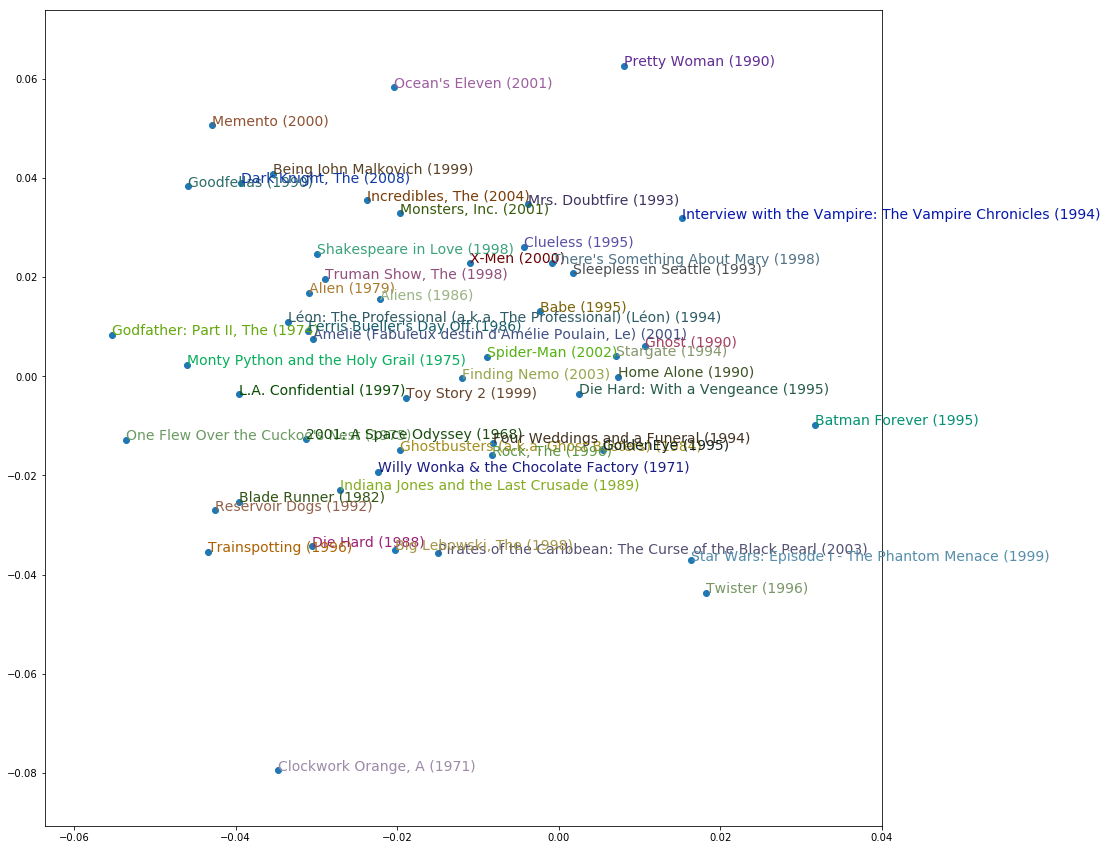

In [68]:
start=50; end=100
X = fac0[start:end]
Y = fac2[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names[movieId_index_inverse[i]], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()